# STAT3609 - Group Project
## 20-21 Semester 1, Group 2
## Candlestick Analysis: Prediction of Hong Kong and Korean Stock Market Trend
### Members
- Nyeongmin
- Hailey
- Alan
- Isaac

### Data
- HK market: HSI index<br>
- KR market: KOSPI 50 index
- Date range: recent 9 years, `2011-11-07` to `2020-11-06`

Code written by : Nyeongmin and Hailey

Main working parts while collaborated together on every part,
- Hailey:
    - Pattern recognition
    - Boxplot
    - T test
- Nyeongmin:
    - Data collection
    - Candlestick chart
    - Making dataframes
    - QQ plot
    - Cleaning up the codes and the notebook(.ipynb)

## Load Libraries
If not installed, do `!pip install *library_name*`<br>
`talib` can be installed by the cell below

In [1]:
# Delete ''' to uncomment and install TA-Lib
# May differ by OS, python versions, etc.
'''
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
'''

'\n!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb\n!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb\n!dpkg -i libta.deb ta.deb\n!pip install ta-lib\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import numpy as np

from statsmodels.graphics.gofplots import qqplot

import talib

from scipy import stats
import math

## Prepare Data
Call csv files in the same directory with the source code.

### Functions to make dataframe

In [3]:
#from 2781th index (to match KOSPI data period)
def hsi_make_df(data):
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close','Volume']
    data = data.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
    return data

def kospi_make_df(data):
    data.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Var']
    data = data.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

    # remove thousands separator
    data['High'] = data["High"].str.replace(",","").astype(float)
    data['Open'] = data["Open"].str.replace(",","").astype(float)
    data['Low'] = data["Low"].str.replace(",","").astype(float)
    data['Close'] = data["Close"].str.replace(",","").astype(float)

    # date formatting
    data['Date'] = pd.to_datetime(data['Date'], format='%Y년 %m월 %d일')
    return data

### Load Data

In [4]:
hsi = pd.read_csv("HSI.csv")
hsi = hsi_make_df(hsi)

kospi = pd.read_csv("KOSPI 50 daily.csv")
kospi = kospi_make_df(kospi)

In [5]:
kospi.head()

,Date,Open,High,Low,Close
0,2020-11-06,2247.32,2260.89,2236.10,2246.10
1,2020-11-05,2198.19,2237.42,2195.18,2237.42
2,2020-11-04,2185.13,2196.21,2166.28,2185.34
3,2020-11-03,2144.48,2171.62,2143.66,2168.65
4,2020-11-02,2107.50,2132.09,2097.53,2128.86


In [6]:
# Reindex to match KOSPI timeline - descending by date
hsi=hsi.sort_values(by='Date', ascending=False)
hsi = hsi.reset_index(drop=True)

# Match decimal point with KOSPI
hsi=hsi.round(2)
hsi.head()

,Date,Open,High,Low,Close
0,2020-11-06,25750.78,25799.97,25540.98,25712.97
1,2020-11-05,25500.91,25695.92,25343.44,25695.92
2,2020-11-04,24790.00,25093.72,24733.23,24886.14
3,2020-11-03,24689.56,25048.53,24689.51,24939.73
4,2020-11-02,24274.83,24486.02,24232.66,24460.01


In [7]:
# index to list of integers
hsi.index = list(hsi.index)
kospi.index = list(kospi.index)

In [8]:
hsi['Date'] = pd.to_datetime(hsi['Date'])
hsi['Date'].head()

0   2020-11-06
1   2020-11-05
2   2020-11-04
3   2020-11-03
4   2020-11-02
Name: Date, dtype: datetime64[ns]

## Candlestick Chart

In [9]:
def candlestick_chart(daily):
    # change 'daily' to change dataframe
    df=daily.copy()
    # mpl_finance
    df['Date'] = df['Date'].apply(mpl_dates.date2num)
    df = df.astype(float)

    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(20,12))

    candlestick_ohlc(ax, df[:250].values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    # Setting labels & titles
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Formatting Date
    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    fig.tight_layout()

Text(0.5, 0.98, 'Daily Candlestick Chart of HSI')

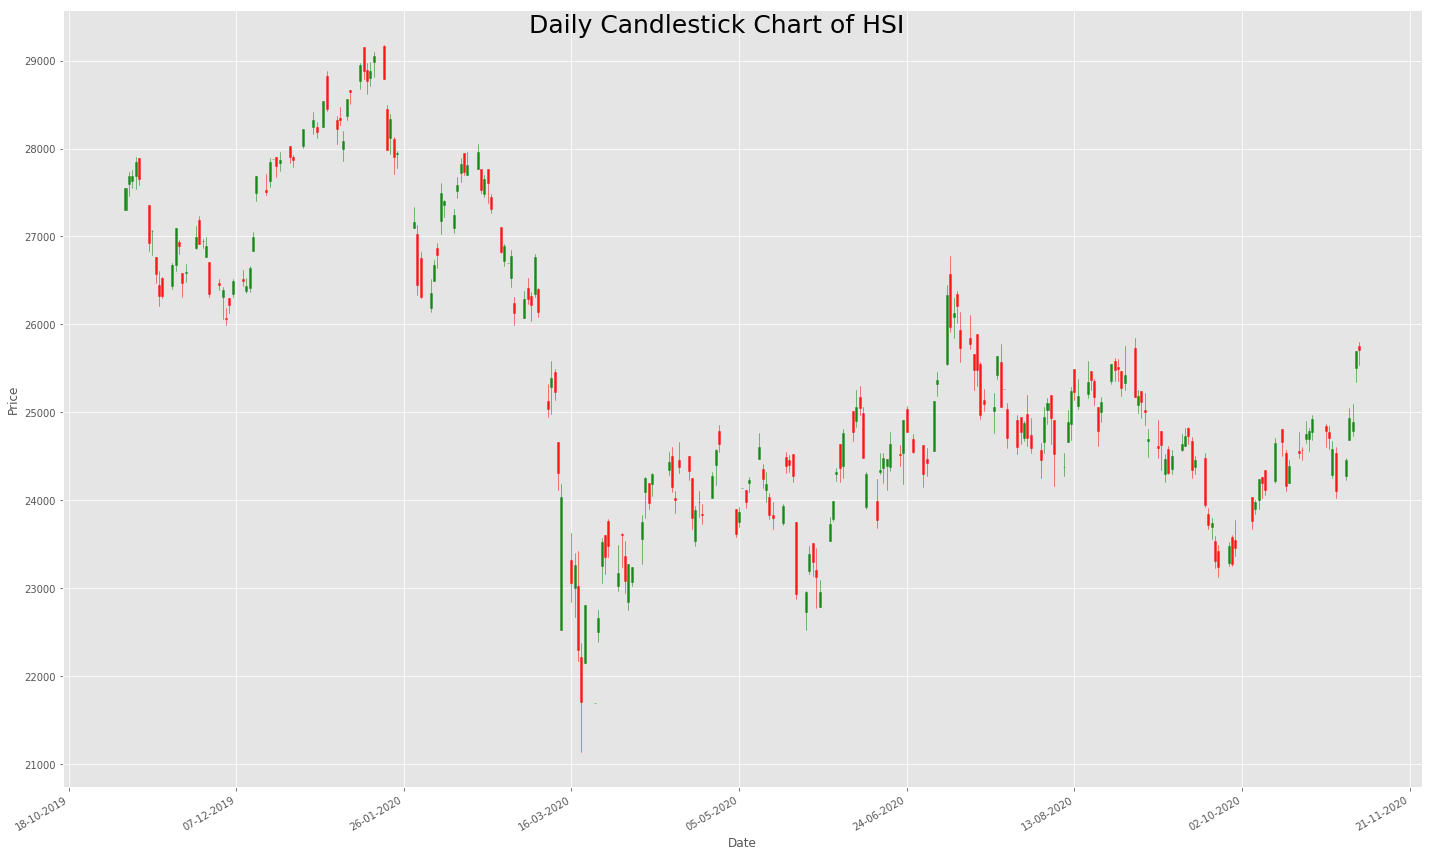

In [10]:
candlestick_chart(hsi)
plt.suptitle('Daily Candlestick Chart of HSI', fontsize=25)

Text(0.5, 0.98, 'Daily Candlestick Chart of KOSPI 50')

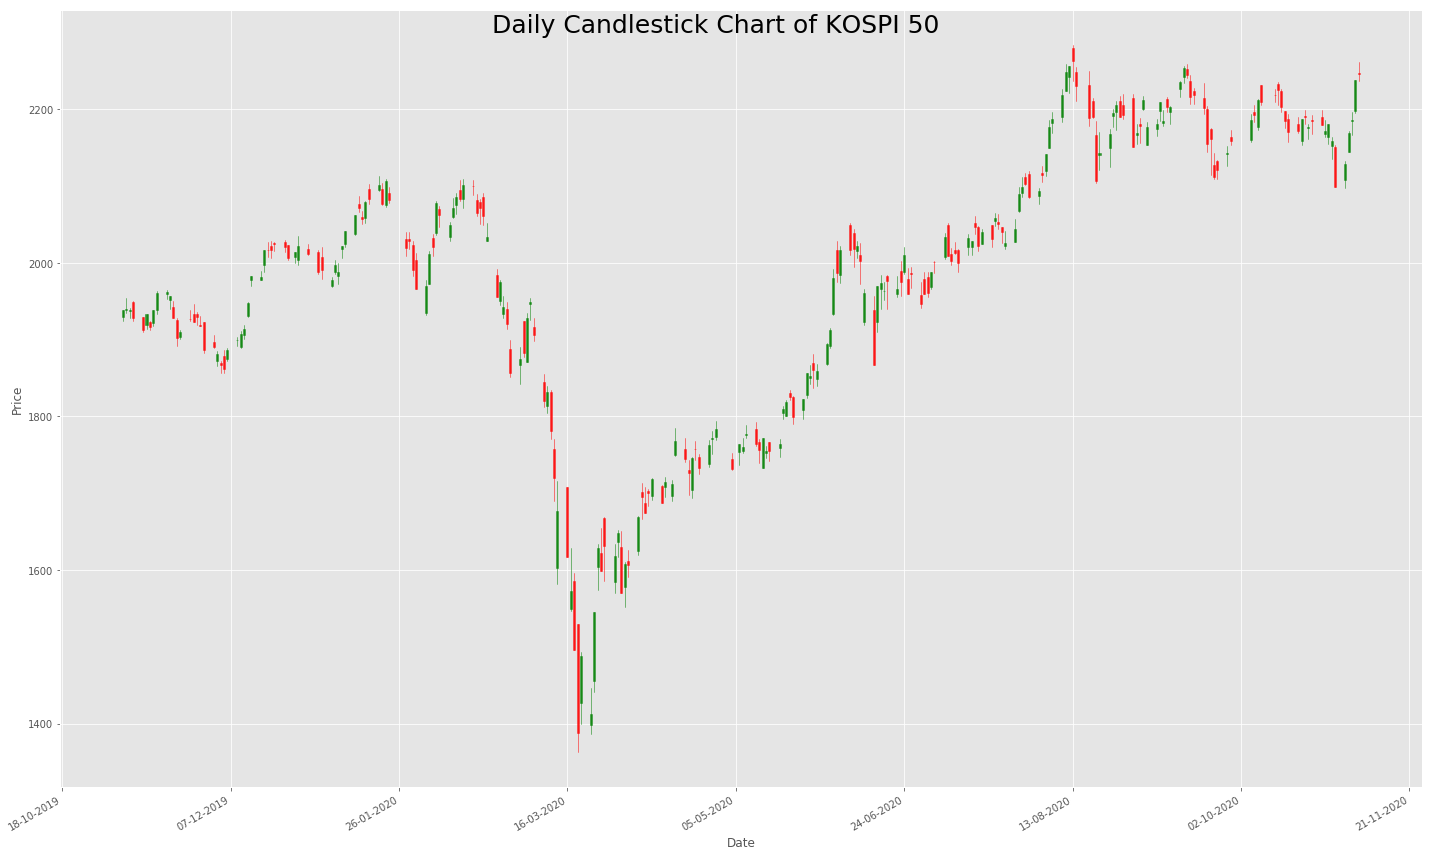

In [11]:
candlestick_chart(kospi)
plt.suptitle('Daily Candlestick Chart of KOSPI 50', fontsize=25)

## Candlestick Pattern Recognition

In [12]:
candle_names = talib.get_function_groups()['Pattern Recognition']

#Number of all candlestick patterns in the list
len(candle_names)

61

TA-Lib creates individual columns for each pattern.
- 0 : no pattern
- +ve values : bullish patterns
- -ve values : bearish patterns.

`get_cdl(df)` to make dataframe of pattern recognition result.

In [13]:
def get_pattern(price):
    # price : daily stock price record
    # dfcopy : start candlestick analysis
    dfcopy=price.copy()
    # extract OHLC 
    op = dfcopy['Open']
    hi = dfcopy['High']
    lo = dfcopy['Low']
    cl = dfcopy['Close']

    # create columns for each pattern
    for candle in candle_names:
        # below is same as;
        # price["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
        dfcopy[candle] = getattr(talib, candle)(op, hi, lo, cl)
    
    return dfcopy

def get_cdl(price):
    #Remove Date&OHLC data and import only candlestick data 
    dfcopy_cdl=get_pattern(price).iloc[:, 5:]
    dfcopy_cdl=dfcopy_cdl.replace(0, np.nan)
    
    #column dropped (Candlestick that does not appear)
    dfcopy_cdl=dfcopy_cdl.dropna(axis=1, how="all")

    #raw dropped (Dates without any candlestick pattern)
    dfcopy_cdl=dfcopy_cdl.dropna(axis=0, how="all")
    
    return dfcopy_cdl

In [14]:
hsi_cdl = get_cdl(hsi)
kospi_cdl = get_cdl(kospi)

hsi_test = hsi_cdl.loc[:, hsi_cdl.count() > 25]
kospi_test = kospi_cdl.loc[:, kospi_cdl.count() > 25]

In [15]:
hsi_cdl.head(10)

,CDL3INSIDE,CDL3OUTSIDE,CDLBELTHOLD,CDLCLOSINGMARUBOZU,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,...,CDLPIERCING,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLXSIDEGAP3METHODS
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,NaN,...,NaN,100.0,NaN,NaN,NaN,-100.0,100.0,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-100.0,NaN,NaN,NaN,NaN
14,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,-100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,-100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
hsi_test.count()

CDLBELTHOLD           159
CDLCLOSINGMARUBOZU    115
CDLDOJI                94
CDLENGULFING          146
CDLHAMMER              29
CDLHARAMI              50
CDLHIGHWAVE            74
CDLHIKKAKE            185
CDLLONGLEGGEDDOJI      88
CDLLONGLINE           158
CDLMARUBOZU            35
CDLRICKSHAWMAN         64
CDLSHORTLINE           85
CDLSPINNINGTOP        152
dtype: int64

In [17]:
kospi_test.count()

CDLBELTHOLD           421
CDLCLOSINGMARUBOZU    389
CDLDOJI               293
CDLDRAGONFLYDOJI       28
CDLENGULFING          156
CDLHAMMER              62
CDLHANGINGMAN          62
CDLHARAMI             160
CDLHARAMICROSS         55
CDLHIGHWAVE           274
CDLHIKKAKE            192
CDLHOMINGPIGEON        45
CDLINVERTEDHAMMER      41
CDLLONGLEGGEDDOJI     277
CDLLONGLINE           466
CDLMARUBOZU           153
CDLMATCHINGLOW         44
CDLRICKSHAWMAN        221
CDLSHORTLINE          227
CDLSPINNINGTOP        441
CDLTAKURI              28
dtype: int64

### Separate bullish & bearish dataset
`get_bull(df)` or `get_bear(df)`

In [18]:
def get_bull(test):
    # bull: df with all bullish patterns detected
    bull = test[test > 0]
    bull = bull.loc[:, bull.count() > 25]
    bull = bull.dropna(axis=0, how="all") # dropped the rows without bull patterns
    return bull

def get_bear(test):
    # bear: df with all bearish patterns detected
    bear = test[test < 0]
    bear = bear.loc[:, bear.count() > 25]
    bear = bear.dropna(axis=0, how="all") # dropped the rows without bear patterns
    return bear

In [19]:
hsi_bull = get_bull(hsi_test)
hsi_bear = get_bear(hsi_test)

kospi_bull = get_bull(kospi_test)
kospi_bear = get_bear(kospi_test)

hsi_bull.count()

CDLBELTHOLD           56
CDLCLOSINGMARUBOZU    68
CDLDOJI               94
CDLENGULFING          46
CDLHAMMER             29
CDLHARAMI             33
CDLHIGHWAVE           34
CDLHIKKAKE            92
CDLLONGLEGGEDDOJI     88
CDLLONGLINE           77
CDLRICKSHAWMAN        64
CDLSHORTLINE          45
CDLSPINNINGTOP        75
dtype: int64

## Return ratio
Will be used for statistical analysis.
Use `Makedf_Return(df, price, n)`.<br>
See comments for details of parameters

$$R=\frac{P_1-P_0}{P_0}=\frac{P_1}{P_0}-1$$

In [20]:
# df: dataframe, either 'bull' or 'bear'
# price : dataframe containing daily price data of the index
# n: T1-T0

def Makedf_Return(df,price,n):
    
    Returns = df.copy()
    col = Returns.columns
    row = Returns.index
    for j in col:
        for i in row[df[j].notna()]:
            if (i-n) in price.index:
                Returns.loc[i,j] = (price.iloc[i-n,-1]/price.iloc[i,-1])-1 # last column: Close price
            else: 
                Returns.loc[i,j] = np.nan # NaN for the cases NOT having enough future values

    return Returns

In [21]:
# Return Ratio by daily(1 day), weekly(5 days), annual(250 days)
# days mean trading days.
# roughly weekly & annual

# HSI
hsi_bearR_daily=Makedf_Return(hsi_bear,hsi,1)
hsi_bullR_daily=Makedf_Return(hsi_bull,hsi,1)

hsi_bearR_weekly=Makedf_Return(hsi_bear,hsi,5)
hsi_bullR_weekly=Makedf_Return(hsi_bull,hsi,5)

hsi_bearR_annual=Makedf_Return(hsi_bear,hsi,250)
hsi_bullR_annual=Makedf_Return(hsi_bull,hsi,250)

# KOSPI 50
kospi_bearR_daily=Makedf_Return(kospi_bear,kospi,1)
kospi_bullR_daily=Makedf_Return(kospi_bull,kospi,1)

kospi_bearR_weekly=Makedf_Return(kospi_bear,kospi,5)
kospi_bullR_weekly=Makedf_Return(kospi_bull,kospi,5)

kospi_bearR_annual=Makedf_Return(kospi_bear,kospi,250)
kospi_bullR_annual=Makedf_Return(kospi_bull,kospi,250)

## Assumptions of One sample T-test
- No significant outliers
- Normality

### Outlier Detection
Box plot drawn to visualize outliers

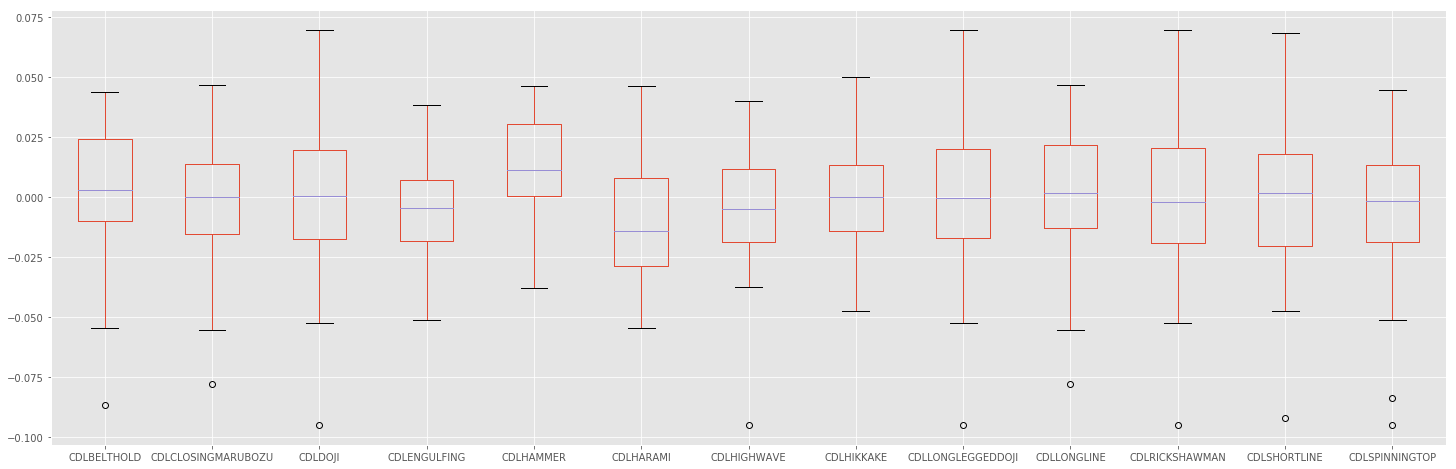

In [22]:
hsi_bullR_weekly.boxplot(figsize=(25,8))

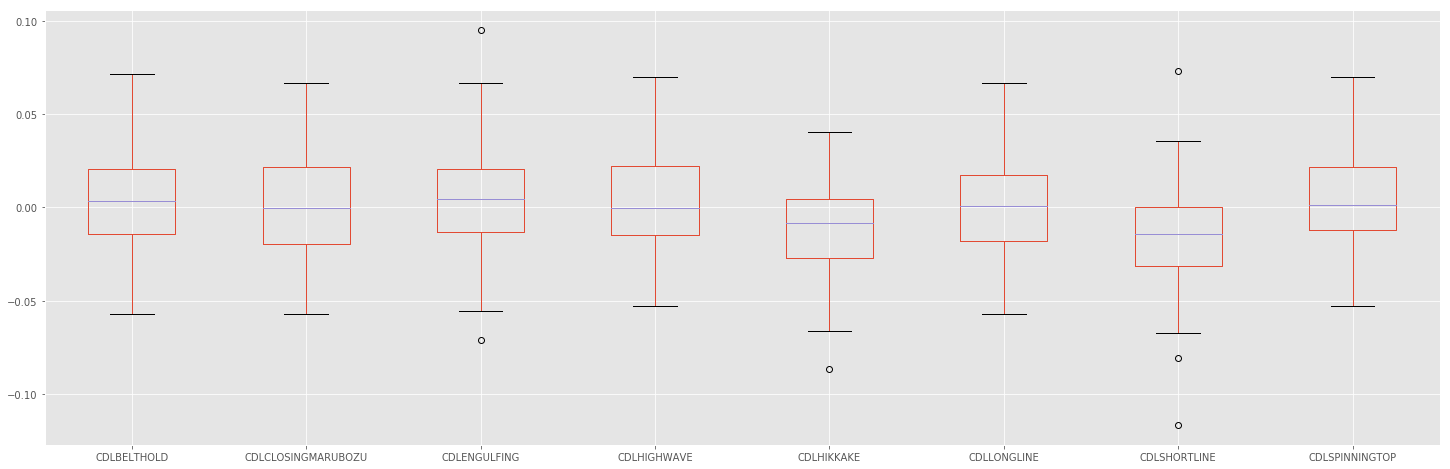

In [23]:
hsi_bearR_weekly.boxplot(figsize=(25,8))

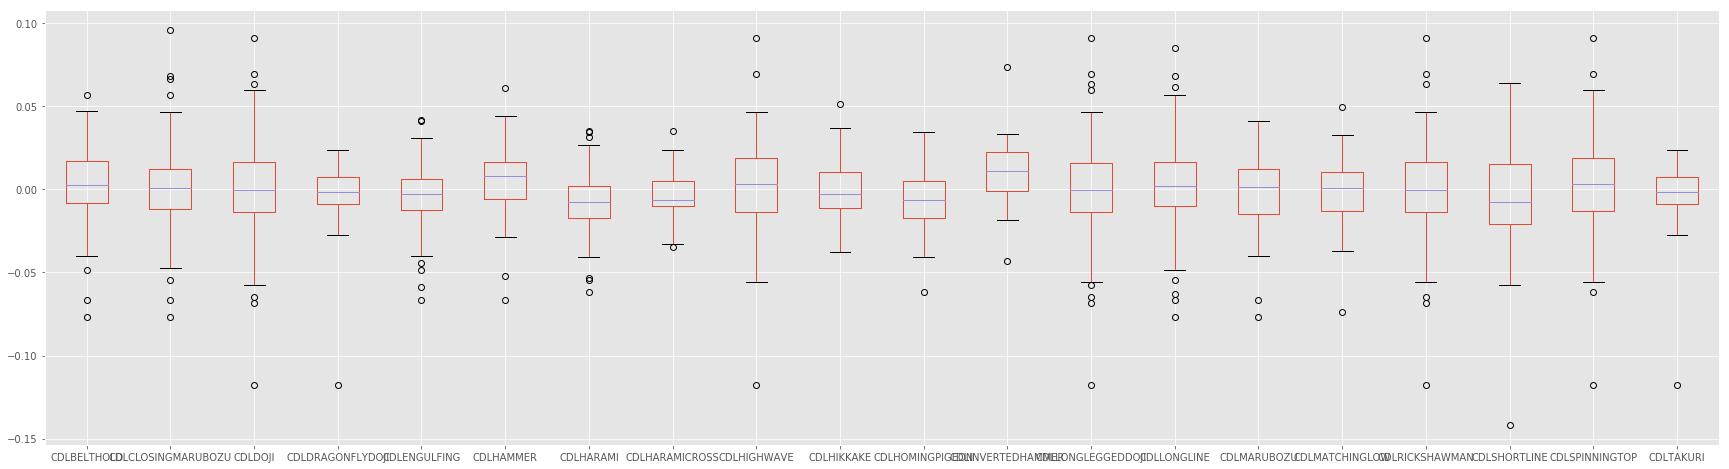

In [24]:
kospi_bullR_weekly.boxplot(figsize=(30,8))

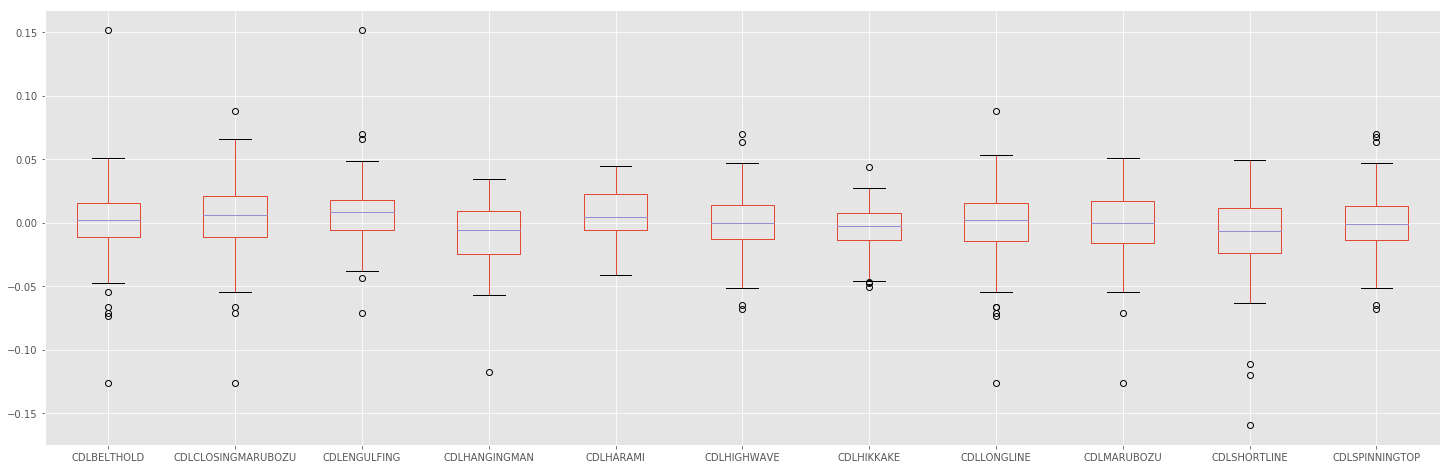

In [25]:
kospi_bearR_weekly.boxplot(figsize=(25,8))

No significant outliers shown, so the first assumption of T-test is valid.

### QQ-plot
To visualize normality<br>
Use `plot_qq(df)`, `df` is bull/bear dataframe

In [26]:
def plot_qq(df):
    if int(df.shape[1])%3 == 0:
        size=int(df.shape[1]/3)
    else:
        size = int(df.shape[1]/3)+1
        
    fig, axs = plt.subplots(size, 3,figsize=(15, 5*size))
    # figure(1)
    for i in range(df.shape[1]):
        ax = fig.add_subplot(size, 3, i+1)
        ax.title.set_text(df.columns[i])
        qqplot(df.iloc[:,i].dropna(), line='s', ax=ax)

    for ax in axs.flat:
        ax.label_outer()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Example - weekly data

Text(0.5, 0.98, 'QQ test on Return Ratio of KOSPI50 (Bearish Patterns, 5-day)')

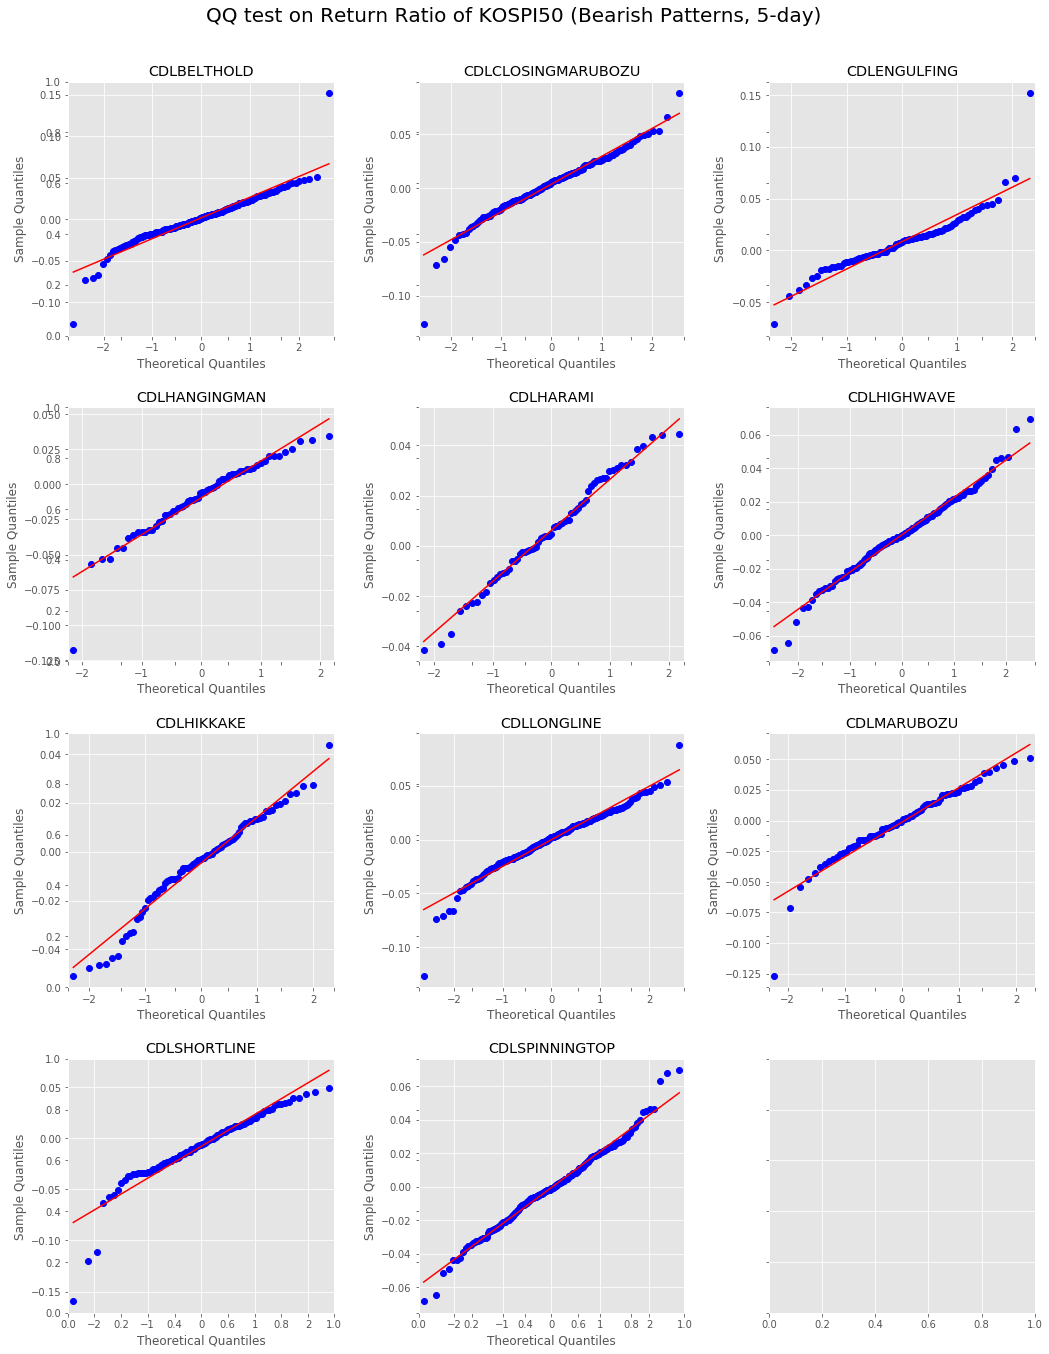

In [27]:
plot_qq(kospi_bearR_weekly)
# change suptitle correspond to the case
plt.suptitle('QQ test on Return Ratio of KOSPI50 (Bearish Patterns, 5-day)', fontsize=20)

Text(0.5, 0.98, 'QQ test on Return Ratio of KOSPI50 (Bullish Patterns, 5-day)')

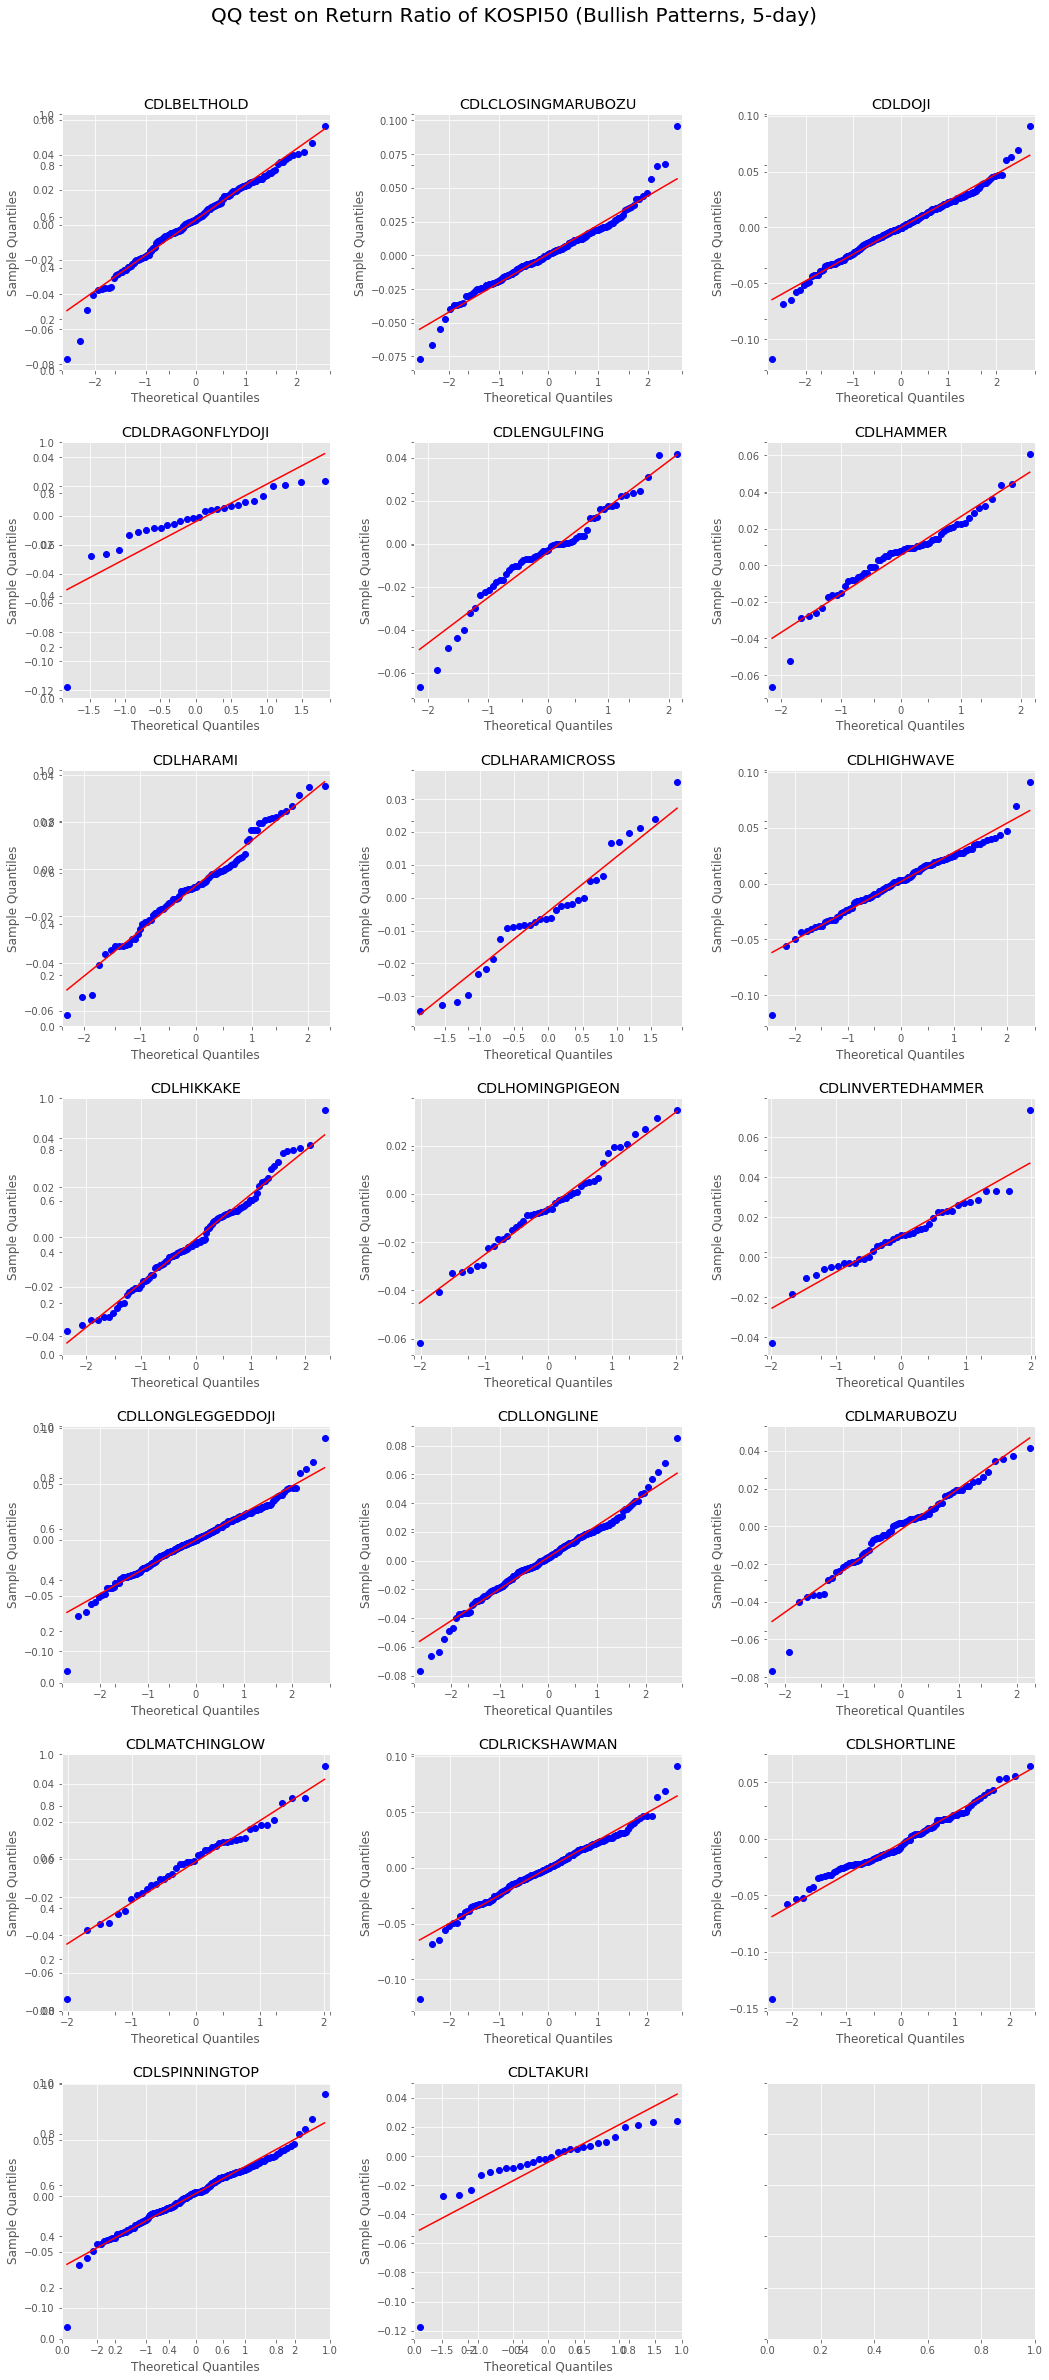

In [28]:
plot_qq(kospi_bullR_weekly)
# change suptitle correspond to the case
plt.suptitle('QQ test on Return Ratio of KOSPI50 (Bullish Patterns, 5-day)', fontsize=20)

Text(0.5, 0.98, 'QQ test on Return Ratio of HSI (Bearish Patterns, 5-day)')

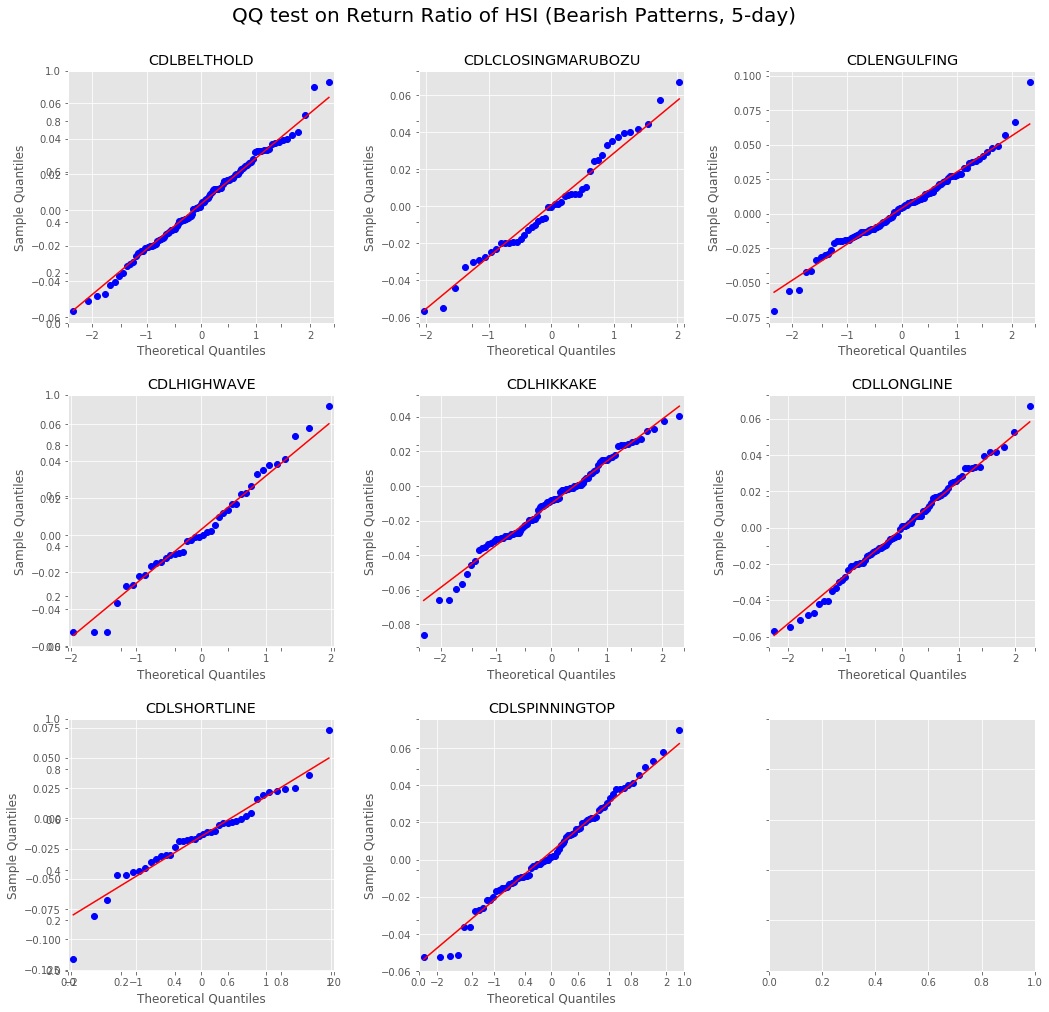

In [29]:
plot_qq(hsi_bearR_weekly)
# change suptitle correspond to the case
plt.suptitle('QQ test on Return Ratio of HSI (Bearish Patterns, 5-day)', fontsize=20)

Text(0.5, 0.98, 'QQ test on Return Ratio of HSI (Bullish Patterns, 5-day)')

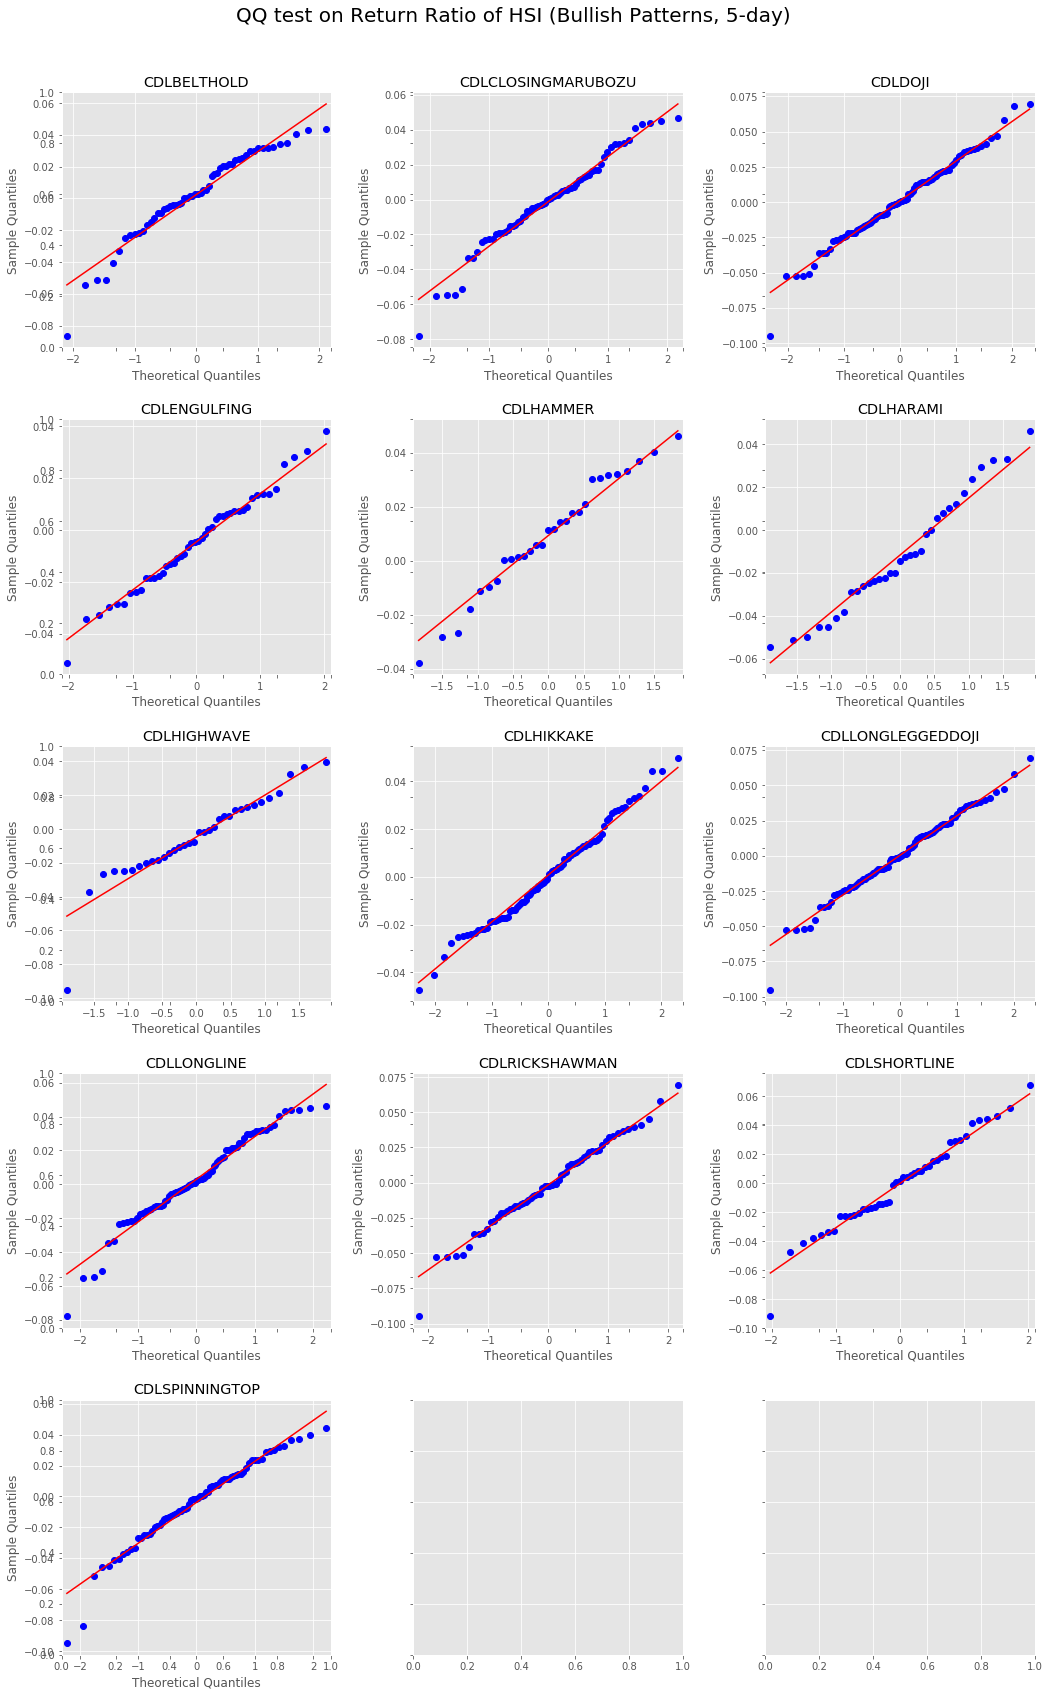

In [30]:
plot_qq(hsi_bullR_weekly)
# change suptitle correspond to the case
plt.suptitle('QQ test on Return Ratio of HSI (Bullish Patterns, 5-day)', fontsize=20)

The plots are mostly linear (close to the red line), so normality assumption for t-test is valid as well.

### JB TEST
*It was initially designed to be used, but excluded since data normality was assumed from QQ plot.*<br><br>
Normality test with quantitative result

- `JBresult(df,alpha)`: return p-values of all patterns
- `JB_succ(df,alpha)`: return patterns that successfully passed JB-test (normal)

#### Difference in 1 day
IF (p-value > 0.01), assume it follows normal distribution

## Hypotheses
- bullish Test: $H_0: \mu=\bar R\text{ vs. }H_1: \mu<\bar R $
- bearish Test: $H_0: -\mu=\bar R\text{ vs. }H_1: -\mu>\bar R$

## T-Test
Testing whether the pattern's bullishness or bearishness is shown in the index prices.<br>
Confidence level 5% is used.
$$
t_{bull}=\frac{\bar R-\mu}{S_{\bar R}}\\
t_{bear}=\frac{\bar R-(-\mu)}{S_{\bar R}}=\frac{\bar R+\mu}{S_{\bar R}}\\
S_{\bar R}=\frac s{\sqrt n}
$$
- `Tresult(df, bull or bear, pct)`
    - bull or bear: put `'bull'` or `'bear'`
    - pct: expected increase/decrease in return ratio to decide bull/bear -ish trend, in decimal

In [31]:
# d : df (assume normal >> use jb-test result)
# bb : 'bear' or 'bull' by pattern
# pct : expected mean of return rate

# show t test result for each pattern
def Ttest(d,bb,pct):
    list=[]
    d=d.dropna()
    n=d.size
    df=n-1
    mean=d.mean()
    std=d.std()
    se=std/math.sqrt(n)
    if bb == 'bear':
        t_ratio=(mean+pct)/se
        t_crit=-stats.t.ppf(1-0.05, df)
    elif bb == 'bull':
        t_ratio=(mean-pct)/se
        t_crit=stats.t.ppf(1-0.05, df)
    list.append(mean)
    list.append(df)
    list.append(std)
    list.append(se)
    list.append(t_ratio)
    list.append(t_crit)
    return list    

# show all t test result in dataframe
def Tresult(d,bb,pct):
    statlist=[]
    for i in range(d.shape[1]):
        statlist.append(Ttest(d.iloc[:,i],bb,pct))
    bear_stat=pd.DataFrame.from_records(statlist, index=d.columns,
                                     columns=['mean','df','std','se','t ratio','t critical'])
    return bear_stat

# only show the patterns that passed t-test
def T_succ(d,bb,pct):
    stat = Tresult(d,bb,pct)
    if bb == 'bear':
        p = [i for i in stat.index if stat.loc[i,'t ratio'] < stat.loc[i,'t critical']]
    elif bb == 'bull':
        p = [i for i in stat.index if stat.loc[i,'t ratio'] > stat.loc[i,'t critical']]
    return stat.loc[p,:]

In [32]:
hsi_bearR_daily.head()

,CDLBELTHOLD,CDLCLOSINGMARUBOZU,CDLENGULFING,CDLHIGHWAVE,CDLHIKKAKE,CDLLONGLINE,CDLSHORTLINE,CDLSPINNINGTOP
5,NaN,NaN,0.014626,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,0.007525,NaN,NaN,NaN,0.007525
13,NaN,NaN,NaN,0.001112,NaN,NaN,NaN,0.001112
15,NaN,NaN,0.009448,NaN,NaN,0.009448,NaN,NaN
16,-0.020617,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### HSI bearish

In [33]:
Tresult(hsi_bearR_daily, 'bear', 0.001)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,-0.000085,102,0.011237,0.001107,0.826184,-1.659930
CDLCLOSINGMARUBOZU,0.000795,46,0.009066,0.001322,1.357590,-1.678660
CDLENGULFING,0.005232,99,0.003574,0.000357,17.433926,-1.660391
CDLHIGHWAVE,0.001696,39,0.012107,0.001914,1.408164,-1.684875
CDLHIKKAKE,-0.003883,92,0.014249,0.001478,-1.951483,-1.661585
CDLLONGLINE,0.000508,80,0.011014,0.001224,1.231914,-1.664125
CDLSHORTLINE,-0.005059,39,0.012625,0.001996,-2.033604,-1.684875
CDLSPINNINGTOP,0.001458,76,0.012871,0.001467,1.675564,-1.665151


In [34]:
Tresult(hsi_bearR_weekly, 'bear', 0.001)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,0.003478,102,0.025580,0.002520,1.776688,-1.659930
CDLCLOSINGMARUBOZU,0.000790,46,0.028368,0.004138,0.432642,-1.678660
CDLENGULFING,0.004087,99,0.026270,0.002627,1.936635,-1.660391
CDLHIGHWAVE,0.002984,39,0.029388,0.004647,0.857309,-1.684875
CDLHIKKAKE,-0.010012,92,0.024509,0.002541,-3.545858,-1.661585
CDLLONGLINE,-0.000533,80,0.026295,0.002922,0.159714,-1.664125
CDLSHORTLINE,-0.014959,39,0.033277,0.005262,-2.653045,-1.684875
CDLSPINNINGTOP,0.004357,76,0.026181,0.002984,1.795336,-1.665151


In [35]:
Tresult(hsi_bearR_annual, 'bear', 0.05)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,-0.046756,66,0.065218,0.007968,0.407172,-1.668271
CDLCLOSINGMARUBOZU,-0.044867,33,0.069792,0.011969,0.428860,-1.692360
CDLENGULFING,0.039796,83,0.145922,0.015921,5.639935,-1.663420
CDLHIGHWAVE,-0.068436,25,0.071158,0.013955,-1.321062,-1.708141
CDLHIKKAKE,0.035519,87,0.133707,0.014253,5.999987,-1.662557
CDLLONGLINE,-0.050959,53,0.066336,0.009027,-0.106185,-1.674116
CDLSHORTLINE,-0.074793,28,0.069251,0.012860,-1.928013,-1.701131
CDLSPINNINGTOP,-0.070470,55,0.079352,0.010604,-1.930387,-1.673034


In [36]:
T_succ(hsi_bearR_weekly, 'bear', 0.001)

,mean,df,std,se,t ratio,t critical
CDLHIKKAKE,-0.010012,92,0.024509,0.002541,-3.545858,-1.661585
CDLSHORTLINE,-0.014959,39,0.033277,0.005262,-2.653045,-1.684875


### HSI bullish

In [37]:
Tresult(hsi_bullR_daily, 'bull', 0.001)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,-0.001978,55,0.015080,0.002015,-1.477740,1.673034
CDLCLOSINGMARUBOZU,-0.002201,67,0.010934,0.001326,-2.414163,1.667916
CDLDOJI,0.002228,93,0.014714,0.001518,0.809092,1.661404
CDLENGULFING,-0.006092,45,0.006358,0.000937,-7.565398,1.679427
CDLHAMMER,0.009462,28,0.007737,0.001437,5.890020,1.701131
CDLHARAMI,-0.008944,32,0.005065,0.000882,-11.276810,1.693889
CDLHIGHWAVE,0.001078,33,0.012919,0.002216,0.035211,1.692360
CDLHIKKAKE,0.001264,91,0.011608,0.001210,0.218166,1.661771
CDLLONGLEGGEDDOJI,0.002242,87,0.014226,0.001517,0.818682,1.662557
CDLLONGLINE,-0.000022,76,0.011739,0.001338,-0.763608,1.665151


In [38]:
Tresult(hsi_bullR_weekly, 'bull', 0.001)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,0.002547,55,0.027237,0.003640,0.425062,1.673034
CDLCLOSINGMARUBOZU,-0.001225,67,0.025767,0.003125,-0.711999,1.667916
CDLDOJI,0.001018,93,0.028347,0.002924,0.006052,1.661404
CDLENGULFING,-0.004548,45,0.018779,0.002769,-2.003627,1.679427
CDLHAMMER,0.009313,28,0.021541,0.004000,2.078269,1.701131
CDLHARAMI,-0.011675,32,0.026996,0.004699,-2.697148,1.693889
CDLHIGHWAVE,-0.004660,33,0.024991,0.004286,-1.320704,1.692360
CDLHIKKAKE,0.000755,91,0.019727,0.002057,-0.119335,1.661771
CDLLONGLEGGEDDOJI,0.000389,87,0.028135,0.002999,-0.203603,1.662557
CDLLONGLINE,0.003023,76,0.025219,0.002874,0.703966,1.665151


In [39]:
Tresult(hsi_bullR_annual, 'bull', 0.05)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,-0.073637,38,0.082366,0.013189,-9.374214,1.685954
CDLCLOSINGMARUBOZU,-0.070863,47,0.083145,0.012001,-10.071069,1.677927
CDLDOJI,-0.069885,62,0.075422,0.009502,-12.616452,1.669804
CDLENGULFING,0.014671,40,0.142766,0.022296,-1.584536,1.683851
CDLHAMMER,-0.085480,21,0.069901,0.014903,-9.090798,1.720743
CDLHARAMI,-0.068575,23,0.068559,0.013995,-8.472898,1.713872
CDLHIGHWAVE,-0.053955,26,0.081957,0.015773,-6.590898,1.705618
CDLHIKKAKE,0.064590,81,0.147929,0.016336,0.893148,1.663884
CDLLONGLEGGEDDOJI,-0.067746,61,0.074086,0.009409,-12.514337,1.670219
CDLLONGLINE,-0.073057,54,0.072671,0.009799,-12.558293,1.673565


In [40]:
T_succ(hsi_bullR_weekly, 'bull', 0.001)

,mean,df,std,se,t ratio,t critical
CDLHAMMER,0.009313,28,0.021541,0.004,2.078269,1.701131


### KOSPI bearish

In [41]:
Tresult(kospi_bearR_daily, 'bear', 0.001)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,0.001085,227,0.010273,0.000680,3.065277,-1.651594
CDLCLOSINGMARUBOZU,0.001939,181,0.012183,0.000903,3.254503,-1.653316
CDLENGULFING,0.007168,94,0.008154,0.000837,9.763331,-1.661226
CDLHANGINGMAN,-0.008306,61,0.007074,0.000898,-8.132474,-1.670219
CDLHARAMI,0.007326,66,0.004466,0.000546,15.260284,-1.668271
CDLHIGHWAVE,0.000909,141,0.011315,0.000950,2.010271,-1.655732
CDLHIKKAKE,-0.000197,86,0.008510,0.000912,0.880189,-1.662765
CDLLONGLINE,0.000999,223,0.010243,0.000684,2.920663,-1.651715
CDLMARUBOZU,0.001705,77,0.011292,0.001279,2.115851,-1.664885
CDLSHORTLINE,-0.002711,116,0.011668,0.001079,-1.586291,-1.658096


In [42]:
Tresult(kospi_bearR_weekly, 'bear', 0.001)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,0.001504,227,0.024939,0.001652,1.515840,-1.651594
CDLCLOSINGMARUBOZU,0.003686,181,0.025924,0.001922,2.438657,-1.653316
CDLENGULFING,0.008234,94,0.026557,0.002725,3.388918,-1.661226
CDLHANGINGMAN,-0.009676,61,0.026350,0.003346,-2.592591,-1.670219
CDLHARAMI,0.006236,66,0.020482,0.002502,2.892016,-1.668271
CDLHIGHWAVE,0.000271,141,0.022386,0.001879,0.676688,-1.655732
CDLHIKKAKE,-0.004628,86,0.018865,0.002023,-1.794003,-1.662765
CDLLONGLINE,-0.000075,223,0.024881,0.001662,0.556307,-1.651715
CDLMARUBOZU,-0.001377,77,0.028460,0.003222,-0.117082,-1.664885
CDLSHORTLINE,-0.008144,116,0.031257,0.002890,-2.472274,-1.658096


In [43]:
Tresult(kospi_bearR_annual, 'bear', 0.05)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,0.017062,207,0.124947,0.008663,7.740800,-1.652248
CDLCLOSINGMARUBOZU,0.025740,162,0.135523,0.010615,7.135187,-1.654314
CDLENGULFING,0.027172,82,0.142679,0.015661,4.927661,-1.663649
CDLHANGINGMAN,0.025010,53,0.151821,0.020660,3.630659,-1.674116
CDLHARAMI,0.038528,57,0.141609,0.018594,4.761081,-1.672029
CDLHIGHWAVE,0.047239,123,0.135920,0.012206,7.966536,-1.657336
CDLHIKKAKE,0.007846,77,0.142523,0.016138,3.584580,-1.664885
CDLLONGLINE,0.008328,204,0.121114,0.008459,6.895347,-1.652357
CDLMARUBOZU,0.009246,72,0.103190,0.012077,4.905527,-1.666294
CDLSHORTLINE,0.028687,105,0.155927,0.015145,5.195563,-1.659495


In [44]:
T_succ(kospi_bearR_weekly, 'bear', 0.001)

,mean,df,std,se,t ratio,t critical
CDLHANGINGMAN,-0.009676,61,0.026350,0.003346,-2.592591,-1.670219
CDLHIKKAKE,-0.004628,86,0.018865,0.002023,-1.794003,-1.662765
CDLSHORTLINE,-0.008144,116,0.031257,0.002890,-2.472274,-1.658096


### KOSPI bullish

In [45]:
Tresult(kospi_bullR_daily, 'bull', 0.001)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,0.000098,192,0.008473,0.000610,-1.478756,1.652829
CDLCLOSINGMARUBOZU,0.000152,206,0.009645,0.000670,-1.264930,1.652284
CDLDOJI,-0.000445,292,0.010675,0.000624,-2.316403,1.650089
CDLDRAGONFLYDOJI,-0.002796,27,0.008858,0.001674,-2.267772,1.703288
CDLENGULFING,-0.004911,60,0.003024,0.000387,-15.267240,1.670649
CDLHAMMER,0.006547,61,0.006640,0.000843,6.577953,1.670219
CDLHARAMI,-0.007797,92,0.006635,0.000688,-12.785309,1.661585
CDLHARAMICROSS,-0.007603,31,0.005940,0.001050,-8.192061,1.695519
CDLHIGHWAVE,-0.000768,131,0.011046,0.000961,-1.838844,1.656569
CDLHIKKAKE,0.000311,104,0.008954,0.000874,-0.788474,1.659637


In [46]:
Tresult(kospi_bullR_weekly, 'bull', 0.001)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,0.002733,192,0.020312,0.001462,1.184973,1.652829
CDLCLOSINGMARUBOZU,0.000858,206,0.021615,0.001502,-0.094499,1.652284
CDLDOJI,-0.000059,292,0.023916,0.001397,-0.757744,1.650089
CDLDRAGONFLYDOJI,-0.004233,27,0.026129,0.004938,-1.059844,1.703288
CDLENGULFING,-0.003885,60,0.021358,0.002735,-1.786308,1.670649
CDLHAMMER,0.005475,61,0.021291,0.002704,1.654818,1.670219
CDLHARAMI,-0.007042,92,0.019278,0.001999,-4.022946,1.661585
CDLHARAMICROSS,-0.004218,31,0.017000,0.003005,-1.736472,1.695519
CDLHIGHWAVE,0.001829,131,0.026216,0.002282,0.363423,1.656569
CDLHIKKAKE,-0.000778,104,0.017958,0.001753,-1.014532,1.659637


In [47]:
Tresult(kospi_bullR_annual, 'bull', 0.05)

,mean,df,std,se,t ratio,t critical
CDLBELTHOLD,0.040722,170,0.145065,0.011093,-0.836349,1.653866
CDLCLOSINGMARUBOZU,0.039412,184,0.138611,0.010191,-1.038957,1.653177
CDLDOJI,0.040073,265,0.132043,0.008096,-1.226205,1.650624
CDLDRAGONFLYDOJI,0.004740,24,0.137298,0.027460,-1.648222,1.710882
CDLENGULFING,0.036005,55,0.131164,0.017528,-0.798456,1.673034
CDLHAMMER,0.016422,53,0.122482,0.016668,-2.014535,1.674116
CDLHARAMI,0.016106,81,0.119951,0.013246,-2.558770,1.663884
CDLHARAMICROSS,0.014050,27,0.128505,0.024285,-1.480333,1.703288
CDLHIGHWAVE,0.032425,118,0.130946,0.012004,-1.464156,1.657870
CDLHIKKAKE,0.046700,90,0.146869,0.015396,-0.214365,1.661961


In [48]:
T_succ(kospi_bullR_weekly, 'bull', 0.001)

,mean,df,std,se,t ratio,t critical
CDLINVERTEDHAMMER,0.010729,40,0.01853,0.002894,3.361812,1.683851
